## Introduction
In this experiment we are going to implement the Locality Sensitive Hashing(LSH) algorithm to find the possible similar pairs, and optimize the algorithm to find as many true pairs as possible in limited time.

## Data preparation
There are about 100.000 users that watched in total 17.770 movies;
- Each user watched between 300 and 3000 movies
- The file contains about 65.000.000 records (720 MB) of the form:
`<user_id, movie_id> : “user_id watched movie_id”`
- Similarity between users: Jaccard similarity of sets of movies they watched: 
``` 
jsim(S1, S2) = #intersect(S1, S2)/#union(S1, S2)
``` 

In [39]:
# import packages
import numpy as np
import pandas as pd
import time
import csv
from collections import defaultdict
#from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
%matplotlib inline  

t0 = time.time()
np.random.seed(seed=100)

In [40]:
#  load the data
FILE = '../data/user_movie.npy'
df = pd.DataFrame(np.load(FILE), columns = ['user','movie']) #Read the data into dataframe

m_by_u = df.groupby('user')['movie'].apply(list)

In [41]:
import_time = round(time.time()-t0)# Calculate the importing time
print("Packages importing and data preparation take {0:.2f} minutes".format(import_time/60))

Packages importing and data preparation takes 0.50 minutes


## MinHash

The dataset is so small that random permutations is used instead of hash functions. 
In this way we can avoid time consuming loops.

Note: we have compared the computing time for two minhashing function.
1. use csc_matrix with two loops (signature then user)
2. use one loop for users, calculating all sigatures for one user at the same time

**The second method takes about half of them of the 1st one. Therefore, we adopt the second method for minhashing.**

In [42]:
# Relatively short signatures (50-150) should result in good results (and take less time to compute)
n_sig = 150

In [43]:
print('Method 1 is discarded due to slowness')

# set user as the column, movie as the row in the sparse matrix
#mat = csc_matrix(([1]*df.shape[0], (df.iloc[:,1], df.iloc[:,0])))

#n_movie = mat.shape[0]
#n_user = mat.shape[1]

def minhashing(mat, n_sig = n_sig):
    # create the sig matrix using minhashing
    sig_matrix = np.zeros([n_sig, n_user])
    for i in range(n_sig):
        perm = mat[np.random.permutation(n_movie)]
        for j in range(n_user):
            sig_matrix[i,j] = int(perm.indices[perm.indptr[j]:perm.indptr[j+1]].min())
        if i%10==9: # check the progress
            print(n_sig - i - 1,' signatures remaining to be created')
    return sig_matrix
#sig_matrix = minhashing(mat,n_sig)

#cal_time = round(time.time()-import_time)
#print("Minhashing takes {0:.2f} minutes".format(cal_time/60))

Method 1, discarded due to slowness


In [44]:
n_movie = df.movie.max()+1
n_user = df.user.max()+1

def minhashing2(m_by_u, n_sig = n_sig):
    # create the permuation matrix of shape (n_sig, n_movie)
    perm_matrix = np.array([np.random.permutation(n_movie) for i in range(n_sig)])
    sig_matrix = np.zeros([n_sig, n_user])
    
    # loop through users instead of permuations to fill in permuation matrix
    for i,item in m_by_u.items():
        sig =  perm_matrix[:,item].min(axis=1)
        sig_matrix[:,i] = sig
        # check the progress: print out how many users remaining
        if i%10000==0: 
            print(n_user - i - 1,' users remaining')
    return sig_matrix
sig_matrix = minhashing2(m_by_u,n_sig)

103702  users remaining
93702  users remaining
83702  users remaining
73702  users remaining
63702  users remaining
53702  users remaining
43702  users remaining
33702  users remaining
23702  users remaining
13702  users remaining
3702  users remaining


In [45]:
cal_time = round(time.time()-t0)
print("Minhashing completed, taking {0:.2f} minutes".format(cal_time/60 - import_time/60))

Minhashing completed, taking 1.65 minutes


In [46]:
# save/load sig matrix to save time
# np.savetxt('sig.txt', sig_matrix, fmt='%d')
# sig_matrix = np.loadtxt('sig.txt', dtype=int)

## Implement the LSH algorithm

### jsim functions for signatures matrix and movies by user list

In [47]:
def check_estimate_pair(pair,n_sig):
    # check if the pair from the bucket is similar based on sig matrix
    sigi = sig_matrix[:,pair[0]]#.tolist()#.ravel().tolist()[0]
    sigj = sig_matrix[:,pair[1]]#.tolist()#.ravel().tolist()[0]
    # estimate_jsim
    intersect = np.count_nonzero(sigi == sigj)
    jsim = intersect/n_sig
    if jsim > 0.40:
        return True

def check_true_pair(pair):
    # check if the similar pair based on sig matrix is a true pair based on original data
    a = m_by_u[pair[0]]
    b = m_by_u[pair[1]]
    intersect = len(set(a) & set(b))
    union = len(a) + len(b) - intersect
    jsim = intersect/union
    if jsim > 0.5:
        return True

### Choosing bands, rows and the bucket selection creteria
When there are many users that fall into the same bucket then checking if all the potential pairs are really similar might be very expensive, we will leave the bucket with more than 300 items for later. 

In [48]:
bands = 30
rows = 5
max_bucket_item = 300

we have compared the results for two hashing functions.
1. use sum of the band as the hashing function
2. use the tuple of numbers and default hash() 

**The second method dramatically decrease the number of false postive items. We adopt the second method for our assignment**

In [49]:
def LSH_bucket(sig_matrix, max_bucket_item = 25):
    unique_pairs = set() 
    for b in range(bands):
        bucket_list = defaultdict(set) # remove the duplicate items
        s = np.sum(sig_matrix[b*rows:(b+1)*rows,:], axis =0)
        for index, x in np.ndenumerate(s):
            bucket_list[x].add(index[0])
        for key, value in bucket_list.items():
            if len(value) > 1 and len(value) < max_bucket_item: 
                for i in value:
                    for j in value:
                        if i < j and ((i,j) not in unique_pairs): # remove the duplicate pair
                            unique_pairs.add((i,j))
    return unique_pairs

In [50]:
def LSH_bucket_2(sig_matrix, max_bucket_item = 25):
    unique_pairs = set() 
    for b in range(bands):
        bucket_list = defaultdict(set) # remove the duplicate items
        df = pd.DataFrame(sig_matrix[b*rows:(b+1)*rows,:])
        h = df.apply(lambda x: hash(tuple(x)), axis = 0)
        for index, x in np.ndenumerate(h):
            bucket_list[x].add(index[0])
        for key, value in bucket_list.items():
            if len(value) > 1 and len(value) < max_bucket_item: 
                for i in value:
                    for j in value:
                        if i < j and ((i,j) not in unique_pairs): # remove the duplicate pair
                            unique_pairs.add((i,j))
    return unique_pairs

## Check, no write out

In [51]:
def print_not_write():
    unique_pairs = LSH_bucket_2(sig_matrix,max_bucket_item)
    print('Unique pairs: ',len(unique_pairs))

    sim_pairs = []
    for pair in unique_pairs:
        if check_estimate_pair(pair,n_sig):
            sim_pairs.append(pair)
    print('Similar pairs based on sig matrix: ',len(sim_pairs))

    true_pairs = []
    for pair in sim_pairs:
        if check_true_pair(pair):
            true_pairs.append(pair) 
    print('True similar pairs: ', len(true_pairs))
#print_not_write()

#cal_time = round(time.time()-t0)
#print("Total running time is {0:.2f} minutes".format(cal_time/60)) 

## Optimization of LSH
The aim of this experiment is to use LSH find as more true similar pairs as possible in limited time(30 minutes). Therefore, we only consider the running time and the number of true similar pairs(igroring the precision). We are going to maximize the number of similar pairs within 30 minutes by tuning the parametres of LSH. 
 
Generally, higher number of bands implies lower similarity threshold, so the algorithm might find more similar pairs if we increase the number of bands[1], but the running time will be longer and the number of false positive will also increase which cost more memory. We tried several groups of the parametres and record the number of true similar pairs found and the running time.

- Suppose user1, user2 has s similarity
- Then probability user1, user2 identical in one particular band: s^r
- Probability that the signatures agree on one row (1-s^r)^b
- Probability user1, user2 identical in at least one band: 1 - (1-s^r)^b

If we have 150 signatures, the probability of detection for different similarity can be shown in the following figure.

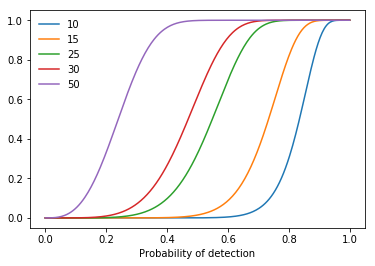

In [52]:
s = np.linspace(0,1,300)
for b in [10,15,25,30,50]:
    plt.plot(s,1 - (1-s**(150/b))**b, label = b)
    plt.legend(loc='upper left', frameon=False) 
    plt.xlabel('s')
    plt.xlabel('Probability of detection')

Too many slices would give a lot of false positives while too few slices would only be able to identify the highest degrees of similarity. From the figure, we can see the b = 25 or 30 seems a good option. In the following table we list the result.

| Group                               | 1        | 2 |  |3|  |4| |
|-----------------------------------|----------|---|---|
| bands                             | 10       | 15 |   |25| |30| |
| rows                              | 15        |10   |   |6|   |5|  |
| True Pairs                     | 1           |  26 |   |373|  |633|    |
| Running Time(min)              | 0.68     |  1.02 |  |4.30| |8.92| |


When the number of bands is greater than 30, we found there are so many candidates(posible similar pairs) that it has reached the limit of our computer. So in this experiment we choiced 30 as the optimal number of bands.

## Write to text file, for final submital

In [56]:
'''
To make sure the program will not exceed the required runtime,
we will close the result.txt file after any new pair is appended to it
'''
def LSH_bucket_true_paris(sig_matrix, max_bucket_item = 25): 
    unique_pairs = set() 
    large_bucket = [] # to save large buckets
    for b in range(bands):
        bucket_list = defaultdict(set)
        df = pd.DataFrame(sig_matrix[b*rows:(b+1)*rows,:])
        h = df.apply(lambda x: hash(tuple(x)), axis = 0)
        for index, x in np.ndenumerate(h):
            # create the buckets
            bucket_list[x].add(index[0])
        # loop through the buckets
        for key, value in bucket_list.items():
            if len(value) > 1:
                if len(value) > max_bucket_item: 
                    large_bucket.append(value)
                else:
                    # find unqiue pairs
                    for i in value:
                        for j in value:
                            if i < j and ((i,j) not in unique_pairs): # remove the duplicate pair
                                unique_pairs.add((i,j))
                                if check_estimate_pair((i,j),n_sig): # if the pairs are similar based on sig matrix
                                    if check_true_pair((i,j)): # if the paris are truly similar based on raw data
                                        with open('ans.txt','a') as file:
                                            # write this pair to ans.txt
                                            writer = csv.DictWriter(file,fieldnames=['user1', 'user2'])
                                            writer.writerow({'user1':i,'user2':j})
    # process large buckets
    print('Process buckets with more than 30 users')
    for value in large_bucket:
        for i in value:
            for j in value:
                if i < j and ((i,j) not in unique_pairs):
                    unique_pairs.add((i,j))
                    if check_estimate_pair((i,j),n_sig): # if the pairs are similar based on sig matrix
                        if check_true_pair((i,j)): # if the paris are truly similar based on raw data
                            with open('ans.txt','a') as file:
                                writer = csv.DictWriter(file,fieldnames=['user1', 'user2'])
                                writer.writerow({'user1':i,'user2':j})            

In [ ]:
LSH_bucket_true_paris(sig_matrix,max_bucket_item)

## Total Time

In [ ]:
cal_time = round(time.time()-t0)
print("Total running time is {0:.2f} minutes".format(cal_time/60))

## Conclusion and Future Work
In this experiment we implement the Locality Sensitive Hashing(LSH) and optimize the number of bands(number of raws within each band). We found 633 pairs within limited time (when disgarding buckets with more than 300 items. 

## Reference:
[1]Gupta, S. (2019, April 1). Locality Sensitive Hashing. Retrieved from https://towardsdatascience.com/understanding-locality-sensitive-hashing-49f6d1f6134.

[2][hash tuple](https://stackoverflow.com/questions/25757042/create-hash-value-for-each-row-of-data-with-selected-columns-in-dataframe-in-pyt/25757564)

[3][hash string](https://www.pythoncentral.io/hashing-strings-with-python/)